In [16]:
import h5py
import re
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
import matplotlib.colors
import itertools
%matplotlib inline
import copy

# This notebook analyzes the R(E) error traces
It loads in the dictionaries in the "rerr_traces.h5" file, and then calculates the mean and credible intervals for the E0 and J0 parameters as a function of the FWHM error on the response amplitude and energy shift

In [17]:
def key2val(key):
    """
    This function reads in the resonse error keys and 
    returns the FWHM percentiles. 
    """
    return tuple(map(int, re.findall(r'\d+', key)))

In [18]:
def printKeys(hf):
    print('Data run,    trace keys')
    for keys in hf.keys():
        print(keys, list(hf[keys].keys()))

Open the h5 file and do statistics on it.

In [19]:
file = '2018_07_11_rerr_traces_.h5'

with h5py.File(file, 'r') as hf:
    #printKeys(hf)
    fKeys = list(hf.keys())
    
    runKeys = list(filter(lambda x: x != 'GLOBAL', hf.keys())) # Ignore global params.
    statDict = {'FWHM_R':np.zeros_like(runKeys, dtype=int), 
                'FWHM_E':np.zeros_like(runKeys, dtype=int),
               'E0_mu':np.zeros_like(runKeys, dtype=float),
                'J0_mu':np.zeros_like(runKeys, dtype=float),
                'E0_ci':np.zeros((len(runKeys), 2), dtype=float),
                'J0_ci':np.zeros((len(runKeys), 2), dtype=float)
               }
    #print(list(hf['GLOBAL'].keys()))
    #print(hf['GLOBAL']['TRUE_E0'][0])
    #statDict['TRUE_E0'] = hf['GLOBAL']['TRUE_E0']
    for i, errSet in enumerate(runKeys): 
        statDict['FWHM_R'][i], statDict['FWHM_E'][i] = key2val(errSet)
        statDict['E0_mu'][i] = np.mean(hf[errSet]['E0'])
        statDict['J0_mu'][i] = np.mean(hf[errSet]['J0'])
        statDict['E0_ci'][i, :] = np.percentile(hf[errSet]['E0'], (2.5, 97.5))
        statDict['J0_ci'][i, :] = np.percentile(hf[errSet]['J0'], (2.5, 97.5))
    statDict['TRUE_E0'] = hf['GLOBAL']['TRUE_E0'].value
    statDict['TRUE_J0'] = hf['GLOBAL']['TRUE_J0'].value

### Visualize the mean $E_0$ and $J_0$ values along the diagonal errors 
(The same FWHM values for both the amplitude and energy R(E) uncertainty)

In [20]:
# Get index array of diagonal elements.
diagInd = np.where(statDict['FWHM_R'] == statDict['FWHM_E'])[0] 
yerr_E0 = np.abs(statDict['E0_ci'][diagInd]-
                 np.repeat(statDict['E0_mu'][diagInd, np.newaxis], 2, axis=1)).T
yerr_J0 = np.abs(statDict['J0_ci'][diagInd]-
                 np.repeat(statDict['J0_mu'][diagInd, np.newaxis], 2, axis=1)).T

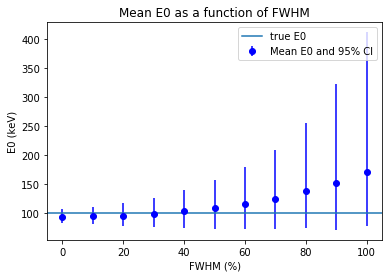

In [21]:
plt.errorbar(statDict['FWHM_R'][diagInd], statDict['E0_mu'][diagInd], 
             yerr=yerr_E0, fmt='bo', label='Mean E0 and 95% CI');
plt.axhline(statDict['TRUE_E0'], label='true E0');
plt.title('Mean E0 as a function of FWHM'); plt.xlabel('FWHM (%)'); 
plt.ylabel('E0 (keV)'); plt.legend();

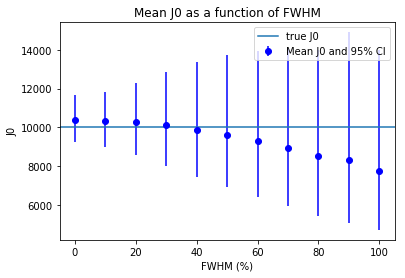

In [22]:
plt.errorbar(statDict['FWHM_R'][diagInd], statDict['J0_mu'][diagInd], 
             yerr=yerr_J0, fmt='bo', label='Mean J0 and 95% CI');
plt.axhline(statDict['TRUE_J0'], label='true J0');
plt.title('Mean J0 as a function of FWHM'); plt.xlabel('FWHM (%)'); 
plt.ylabel('J0'); plt.legend();

### Now visualize the relative error of the mean values of the traces using a mesh plot in the entire FWHM uncertainty space

In [23]:
RR, EE = np.meshgrid(sorted(list(set(statDict['FWHM_R'])) + [110]), 
                     sorted(list(set(statDict['FWHM_E']))) + [110])

In [24]:
C_E = np.nan*np.ones_like(RR)
C_J = np.nan*np.ones_like(RR)

for i, key in enumerate(runKeys):
    Rn, En = key2val(key)
    idx = np.where((Rn == RR) & (En == EE))
    C_E[idx[0][0], idx[1][0]] = 100*(statDict['E0_mu'][i]-
                                     statDict['TRUE_E0'])/statDict['TRUE_E0']
    C_J[idx[0][0], idx[1][0]] = 100*(statDict['J0_mu'][i]-
                                     statDict['TRUE_J0'])/statDict['TRUE_J0']


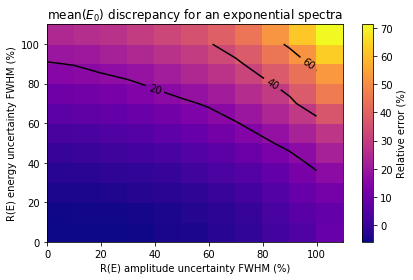

In [50]:
p = plt.pcolormesh(RR, EE, C_E, vmin=np.nanmin(C_E), vmax=np.nanmax(C_E), cmap='plasma');
c = plt.contour(RR, EE, C_E, levels=[20, 40, 60], colors='k')
plt.clabel(c, c.levels, inline=True, fmt='%2d', fontsize=10)
plt.colorbar(p, label='Relative error (%)'); 
plt.xlabel('R(E) amplitude uncertainty FWHM (%)');
plt.ylabel('R(E) energy uncertainty FWHM (%)');
plt.title(r'mean($E_0$) discrepancy for an exponential spectra');
plt.tight_layout()
#plt.savefig('mean_E0_discrepancy_fwhm.png', dpi=300)

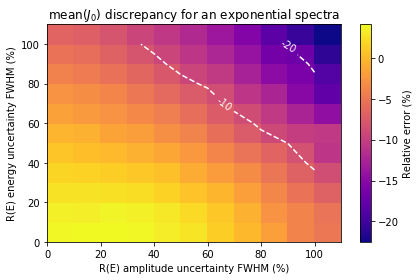

In [53]:
p = plt.pcolormesh(RR, EE, C_J, vmin=np.nanmin(C_J), vmax=np.nanmax(C_J), cmap='plasma');
c = plt.contour(RR, EE, C_J, levels=[-20, -10], colors='w')
plt.clabel(c, c.levels, inline=True, fmt='%2d', fontsize=10)
plt.colorbar(p, label='Relative error (%)'); 
plt.xlabel('R(E) amplitude uncertainty FWHM (%)');
plt.ylabel('R(E) energy uncertainty FWHM (%)');
plt.title(r'mean($J_0$) discrepancy for an exponential spectra');
plt.tight_layout()
#plt.savefig('mean_J0_discrepancy_fwhm.png', dpi=300)

### Statistics of the J0 and E0 distributions that are consistant with the observed counts for a few values of FWHM.

Now we calculate the statistics of 100 spectra drawn from a few FWHM traces(mean, 2.5%, and 95% credible interval) as a function of energy. The keys list controls which FWHM values to plot.

First, get a few traces from the trace file.

In [27]:
traces = {}
keys = ['RERR00_EERR00', 'RERR50_EERR50', 'RERR100_EERR100']
with h5py.File(file, 'r') as hf:
    for key in keys:
        traces[key] = {}
        traces[key]['E0'] = hf[key]['E0'].value
        traces[key]['J0'] = hf[key]['J0'].value

In [28]:
def spectra(E, J0, E0):
    return J0*np.exp(-E/E0)

Pick 100 random draws of E0 and J0 from the trace, and calculate the statistics on those draws as a function of energy.

In [31]:
E = np.arange(20,300)
nS = 100
random_samples = np.random.randint(0, len(traces[keys[0]]['E0']), nS)
dist = np.zeros((len(E), nS, len(keys)), dtype=float)
for (ik, key) in enumerate(keys):
    for (i, s) in enumerate(random_samples):
        for e in range(len(E)):
            dist[e, i, ik] = spectra(E, traces[key]['J0'][s], traces[key]['E0'][s])[e]

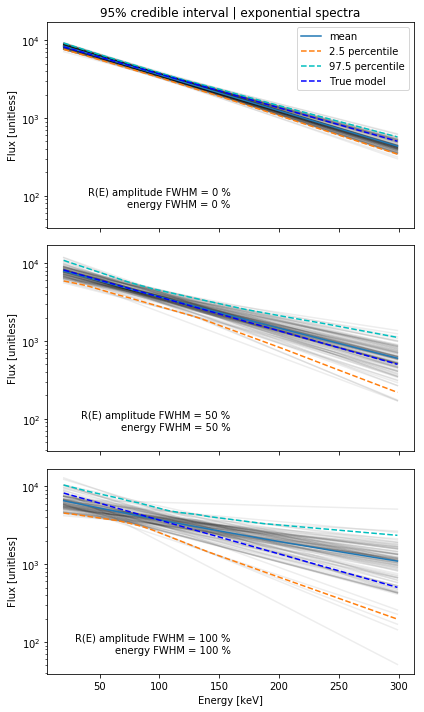

In [35]:
f, axArr = plt.subplots(len(keys), figsize=(6, 10), sharex=True, sharey=True)

for ia, ax in enumerate(axArr):
    for i in random_samples:
        ax.plot(E, spectra(E, traces[keys[ia]]['J0'][i], traces[keys[ia]]['E0'][i]), 
                 c='k', alpha=0.07)
    ax.plot(E, np.mean(dist[:, :, ia], axis=1), label='mean');
    ax.plot(E, np.percentile(dist[:, :, ia], 2.5, axis=1), '--', 
            label='2.5 percentile')
    ax.plot(E, np.percentile(dist[:, :, ia], 97.5, axis=1), '--', 
            label='97.5 percentile', c='c')
    ax.plot(E, spectra(E, statDict['TRUE_J0'], statDict['TRUE_E0']), 'b--', 
            label='True model')
    ax.set_yscale('log'); ax.set_ylabel('Flux [unitless]'); 
    
    s = 'R(E) amplitude FWHM = {} %\nenergy FWHM = {} %'.format(*key2val(keys[ia]))
    ax.text(s=s, x=0.5, y=0.1, transform=ax.transAxes, ha='right')
    
ax.set_xlabel('Energy [keV]');
    
axArr[0].legend()
axArr[0].set_title('95% credible interval | exponential spectra');
plt.tight_layout() 
#plt.savefig('spectra_credible_interval_compare_fwhm.png', dpi=300)

### Now investigate the how the credible interval depends on FWHM

### First, calculate it for $E_0$

In [95]:
# Fit the width of the CI as a function of FWHM.
ci_range = np.diff(statDict['E0_ci'][diagInd], axis=1)[:, 0]
p = np.polyfit(statDict['FWHM_R'][diagInd], np.log(ci_range), 1)

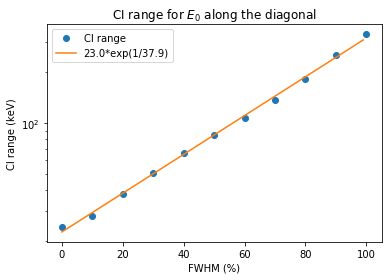

In [96]:
fwhm = np.arange(np.min(statDict['FWHM_R']), np.max(statDict['FWHM_R']));
plt.semilogy(statDict['FWHM_R'][diagInd], ci_range,'o', label='CI range');
plt.plot(fwhm, np.exp(p[1])*np.exp(p[0]*fwhm), 
         label='{}*exp(1/{})'.format(round(np.exp(p[1])), round(1/p[0], 2)));

plt.title(r'CI range for $E_0$ along the diagonal'); plt.xlabel('FWHM (%)'); 
plt.ylabel(r'CI range (keV)'); plt.legend();

### First, calculate it for $J_0$

In [97]:
# Fit the width of the CI as a function of FWHM.
ci_range = np.diff(statDict['J0_ci'][diagInd], axis=1)[:, 0]
p = np.polyfit(statDict['FWHM_R'][diagInd], np.log(ci_range), 1)

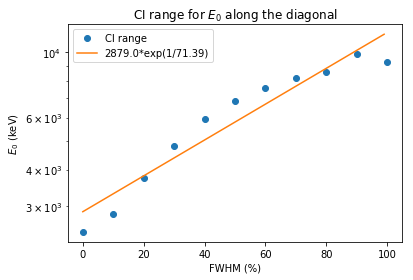

In [98]:
fwhm = np.arange(np.min(statDict['FWHM_R']), np.max(statDict['FWHM_R']));
plt.semilogy(statDict['FWHM_R'][diagInd], ci_range,'o', label='CI range');
plt.plot(fwhm, np.exp(p[1])*np.exp(p[0]*fwhm), 
         label='{}*exp(1/{})'.format(round(np.exp(p[1])), round(1/p[0], 2)));

plt.title(r'CI range for $E_0$ along the diagonal'); plt.xlabel('FWHM (%)'); 
plt.ylabel(r'$E_0$ (keV)'); plt.legend();

### Now investigate how the energy-dependent CI depend on FWHM